## import the dependencies

This notebook contains transfer learning model with changing only CLASSIFIER

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

train_batches = ImageDataGenerator().flow_from_directory(train_path,
                                                         target_size=(224,224),
                                                         batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224),
                                                         batch_size=30)
test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                        target_size=(224,224),
                                                        batch_size=50,
                                                        shuffle=False)

Found 202 images belonging to 2 classes.
Found 103 images belonging to 2 classes.
Found 451 images belonging to 2 classes.


## Load the pretrained model (VGG_16)

In [3]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 12s 0us/step


In [4]:
for layer in base_model.layers:
    layer.trainable = False

## Add the new classifier

In [5]:
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

x = Flatten()(last_output)

x = Dense(64, activation='relu', name='FC_2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax', name='softmax')(x)

new_model = Model(inputs=base_model.input, outputs=x)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Compile and run the training process

In [6]:
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = new_model.fit_generator(train_batches, steps_per_epoch=4, validation_data=valid_batches,
                                 validation_steps=2, epochs=20, verbose=2)

/home/biba_bo/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/home/biba_bo/.local/lib/python3.6/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
4/4 - 8s - loss: 1.3664 - accuracy: 0.5250 - val_loss: 8.6322 - val_accuracy: 0.4667
Epoch 2/20
4/4 - 1s - loss: 0.8316 - accuracy: 0.6500 - val_loss: 5.9578 - val_accuracy: 0.4667
Epoch 3/20
4/4 - 1s - loss: 0.7556 - accuracy: 0.6750 - val_loss: 4.1577 - val_accuracy: 0.5667
Epoch 4/20
4/4 - 1s - loss: 0.7071 - accuracy: 0.8000 - val_loss: 2.9370 - val_accuracy: 0.6167
Epoch 5/20
4/4 - 1s - loss: 0.3903 - accuracy: 0.8750 - val_loss: 2.4900 - val_accuracy: 0.5500
Epoch 6/20
4/4 - 2s - loss: 0.8509 - accuracy: 0.7188 - val_loss: 2.3602 - val_accuracy: 0.6500
Epoch 7/20
4/4 - 1s - loss: 0.2715 - accuracy: 0.9000 - val_loss: 1.3048 - val_accuracy: 0.7500
Epoch 8/20
4/4 - 1s - loss: 0.4170 - accuracy: 0.8250 - val_loss: 1.2166 - val_accuracy: 0.7667
Epoch 9/20
4/4 - 1s - loss: 0.2738 - accuracy: 0.9062 - val_loss: 0.7520 - val_accuracy: 0.8167
Epoch 10/20
4/4 - 1s - loss: 0.2167 - accuracy: 0.8750 - val_loss: 0.8588 - val_accuracy: 0.8000
Epoch 11/20
4/4 - 1s - loss: 0.4978 - a

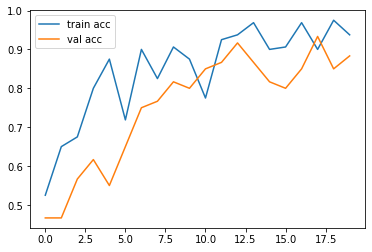

In [8]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

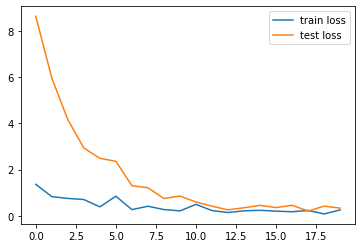

In [9]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()

## Evaluate the model

In [11]:
scores = new_model.evaluate(test_batches, batch_size=128, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores[1] * 100, scores [0]))

10/10 [==============================] - 13s 548ms/step - loss: 0.2425 - accuracy: 0.9202
Test result: 92.018 loss: 0.243
10/10 [==============================] - 5s 459ms/step - loss: 0.2425 - accuracy: 0.9202
Test result: 92.018 loss: 0.243


In [14]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

test_files, test_targets = load_dataset('data/test')

In [16]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))




















100%|██████████| 451/451 [00:01<00:00, 395.39it/s]A


In [17]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

15/15 [==============================] - 9s 377ms/step - loss: 0.1624 - accuracy: 0.9446

Testing loss: 0.1624
Testing accuracy: 0.9446
